# Double Exponential Smoothing - Monthly and Annual Forecast

### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## Monthly Forescast

### Data

In [3]:
np.random.seed(42)  # For reproducibility

# Create a date range (8 years of monthly data)
date_range = pd.date_range(start='2016-01-01', end='2024-12-01', freq='MS')

# Create a time series with trend and seasonality
demand = 100 + np.linspace(0, 50, len(date_range)) + 10 * np.sin(np.linspace(0, 12 * np.pi, len(date_range))) + np.random.normal(0, 5, len(date_range))

# Build DataFrame
df = pd.DataFrame({'Demand': demand}, index=date_range)
df.index.name = 'Month'

### Information of Data

In [4]:
df.describe()

,Demand
count,108.000000
mean,124.487864
std,16.323579
min,86.595521
25%,113.348142
50%,125.211363
75%,136.231727
max,155.512801


### Plot 

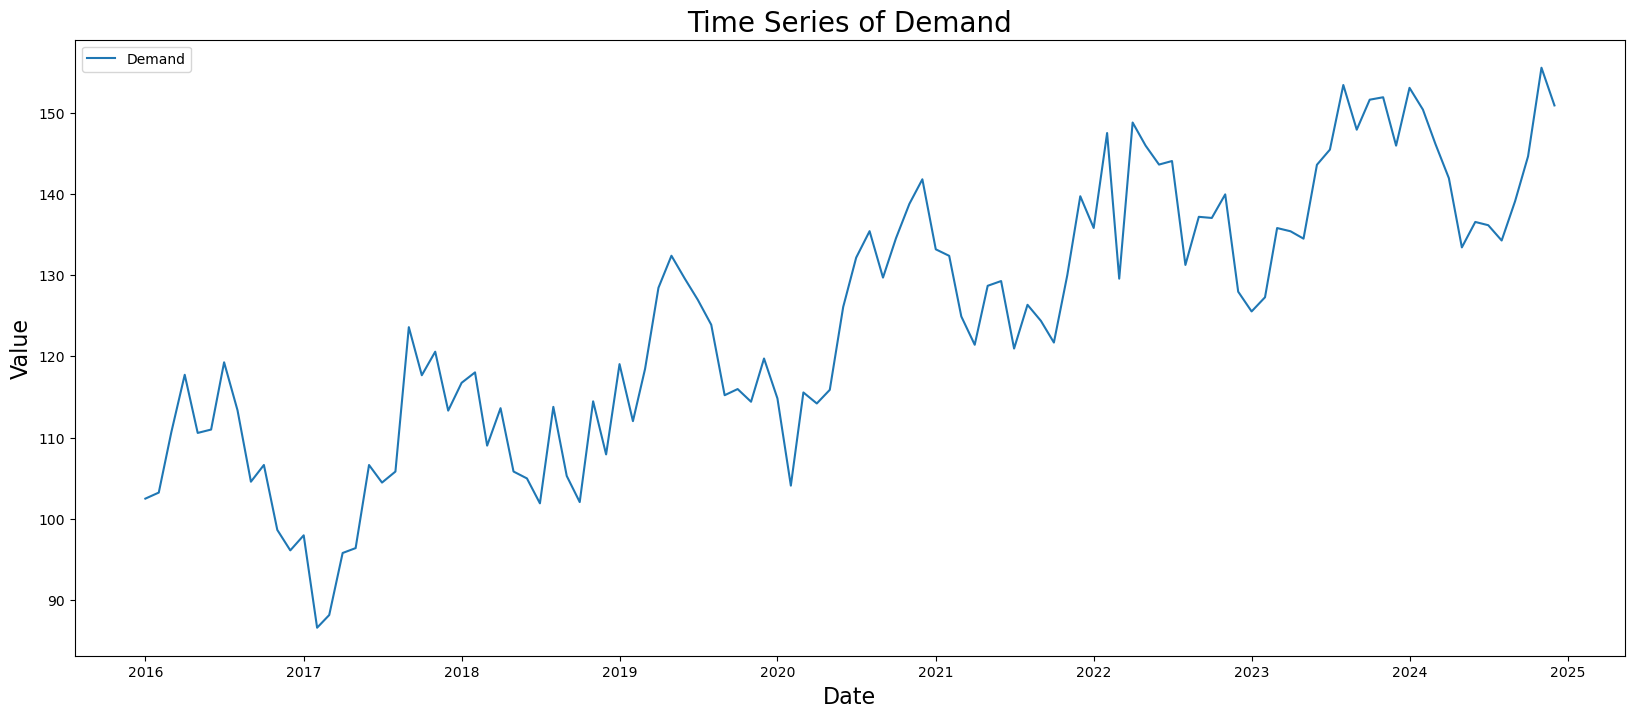

In [5]:
plt.figure(figsize=(20, 8))
plt.plot(df['Demand'], label='Demand')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.title('Time Series of Demand', fontsize=20)
plt.legend()
plt.show()

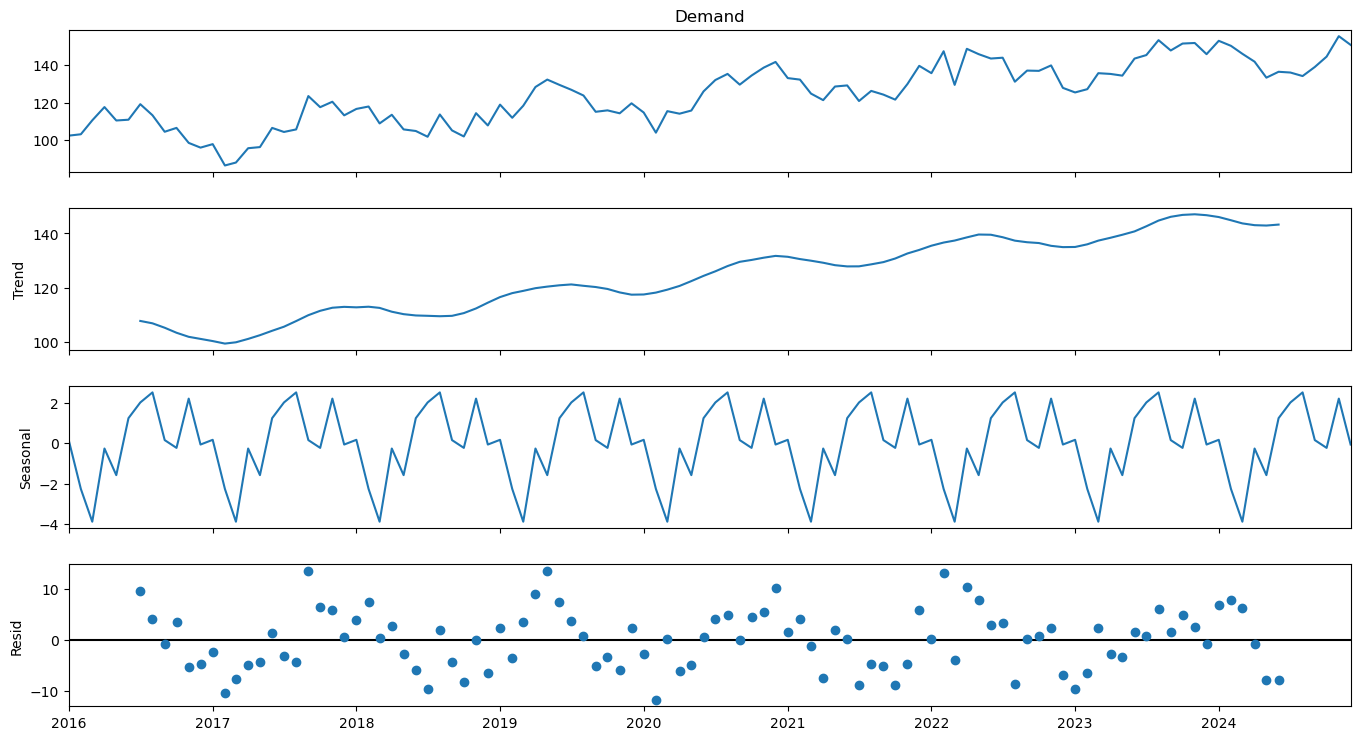

In [6]:
# -------------------------------------------------
# Decompose the series into trend, seasonal, noise
# -------------------------------------------------
decompose_result = seasonal_decompose(df['Demand'])
fig = decompose_result.plot()
fig.set_size_inches(15, 8)
plt.show()

### Apply Double Exponential Smoothing

In [7]:
holt_monthly_model = Holt(df['Demand']).fit(optimized=True)
df['Forecast'] = holt_monthly_model.fittedvalues
print("\nMonthly Model Parameters:\n", holt_monthly_model.params_formatted)


Monthly Model Parameters:
                   name       param  optimized
smoothing_level  alpha    0.746864       True
smoothing_trend   beta    0.000000       True
initial_level      l.0  102.483571      False
initial_trend      b.0    0.743236      False


### Plot observed vs forecast

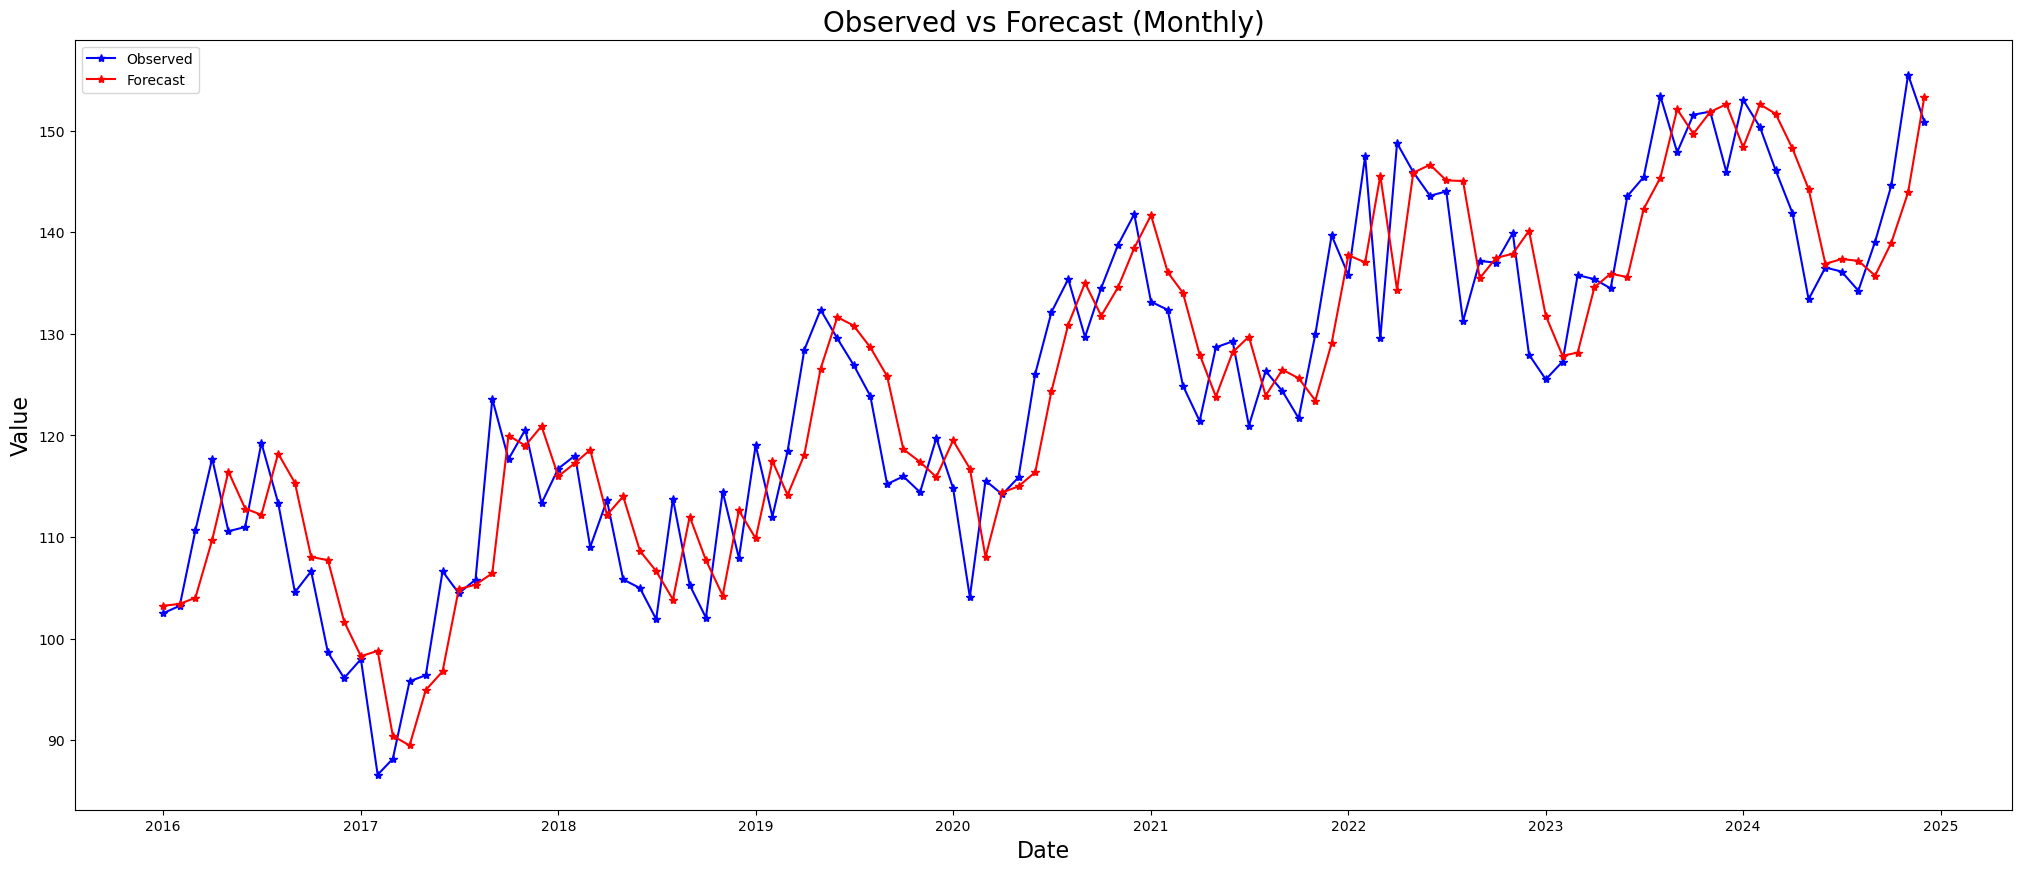

In [8]:
plt.figure(figsize=(25, 10))
plt.plot(df['Demand'], '-*', color='blue', label='Observed')
plt.plot(df['Forecast'], '-*', color='red', label='Forecast')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.title('Observed vs Forecast (Monthly)', fontsize=20)
plt.legend(loc='best')
plt.show()

### Forecast future values

In [9]:
future_prediction = holt_monthly_model.forecast(6)  # Forecast next 6 months
print("Future Forecast:\n", future_prediction)

Future Forecast:
 2025-01-01    152.236357
2025-02-01    152.979593
2025-03-01    153.722829
2025-04-01    154.466065
2025-05-01    155.209302
2025-06-01    155.952538
Freq: MS, dtype: float64


### Combine fitted values with forecast

In [10]:
pred_combined = pd.concat([df['Forecast'], future_prediction])

### Plot combined forecast

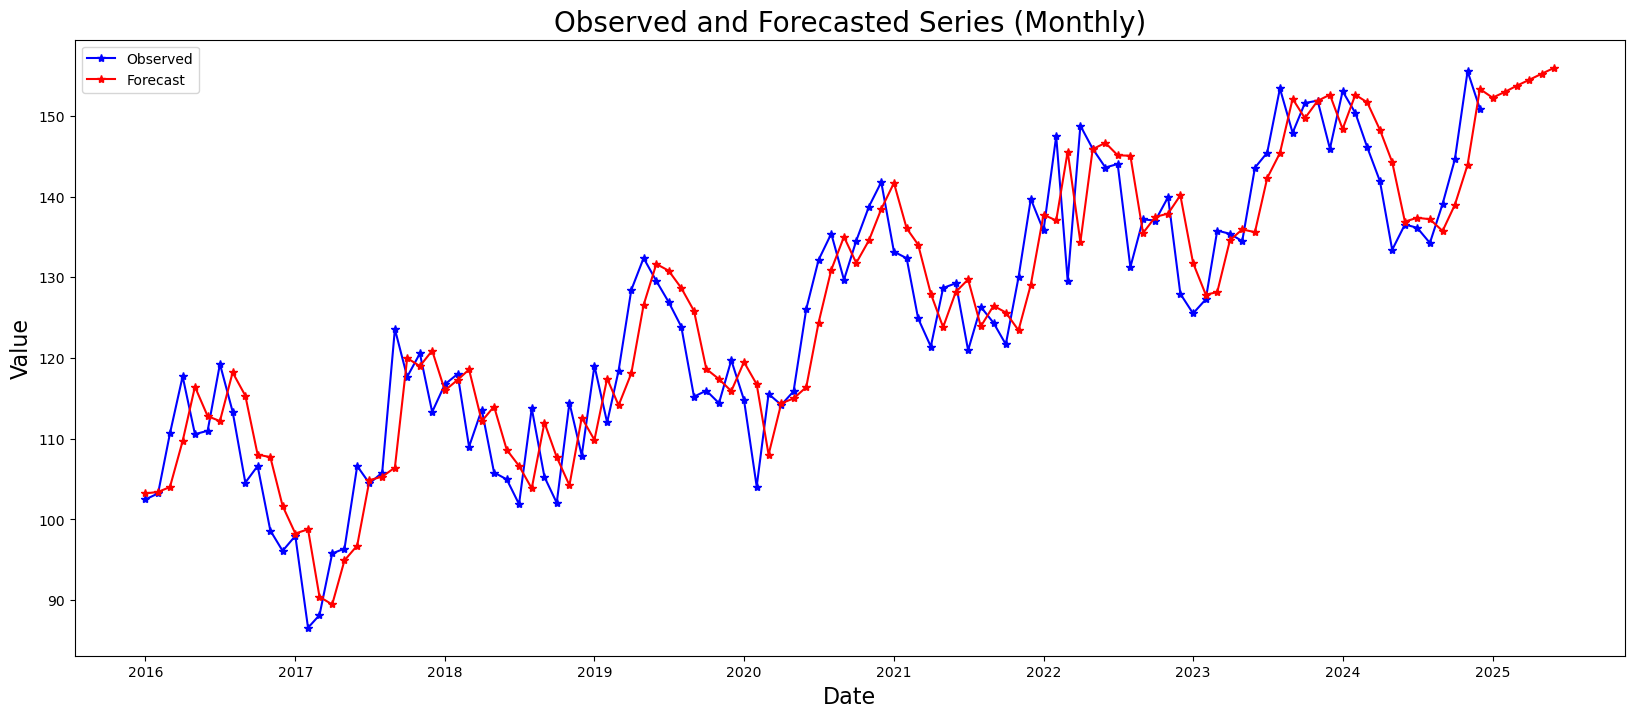

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(df['Demand'], '-*', color='blue', label='Observed')
plt.plot(pred_combined, '-*', color='red', label='Forecast')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.title('Observed and Forecasted Series (Monthly)', fontsize=20)
plt.legend(loc='best')
plt.show()

### Error metrics for forecast

In [12]:
mse = mean_squared_error(df['Demand'], df['Forecast'])
mape = mean_absolute_percentage_error(df['Demand'], df['Forecast'])

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

Mean Squared Error (MSE): 43.40
Mean Absolute Percentage Error (MAPE): 4.33%


## Annual Forescast

In [13]:
### Resample data annually
df_annual = df['Demand'].resample('A').sum().to_frame()
df_annual.index = df_annual.index.strftime('%Y')
df_annual.index.name = 'Year'

print("Annualized Data:\n", df_annual)

Annualized Data:
            Demand
Year             
2016  1294.192924
2017  1256.933326
2018  1313.557184
2019  1455.982262
2020  1502.874962
2021  1532.807394
2022  1668.444054
2023  1698.081732
2024  1721.815509


### Apply Double Exponential Smoothing

In [14]:
annual_model = Holt(df_annual['Demand']).fit(optimized=True)
df_annual['Forecast'] = annual_model.fittedvalues

### Plot observed vs forecast (Annual)


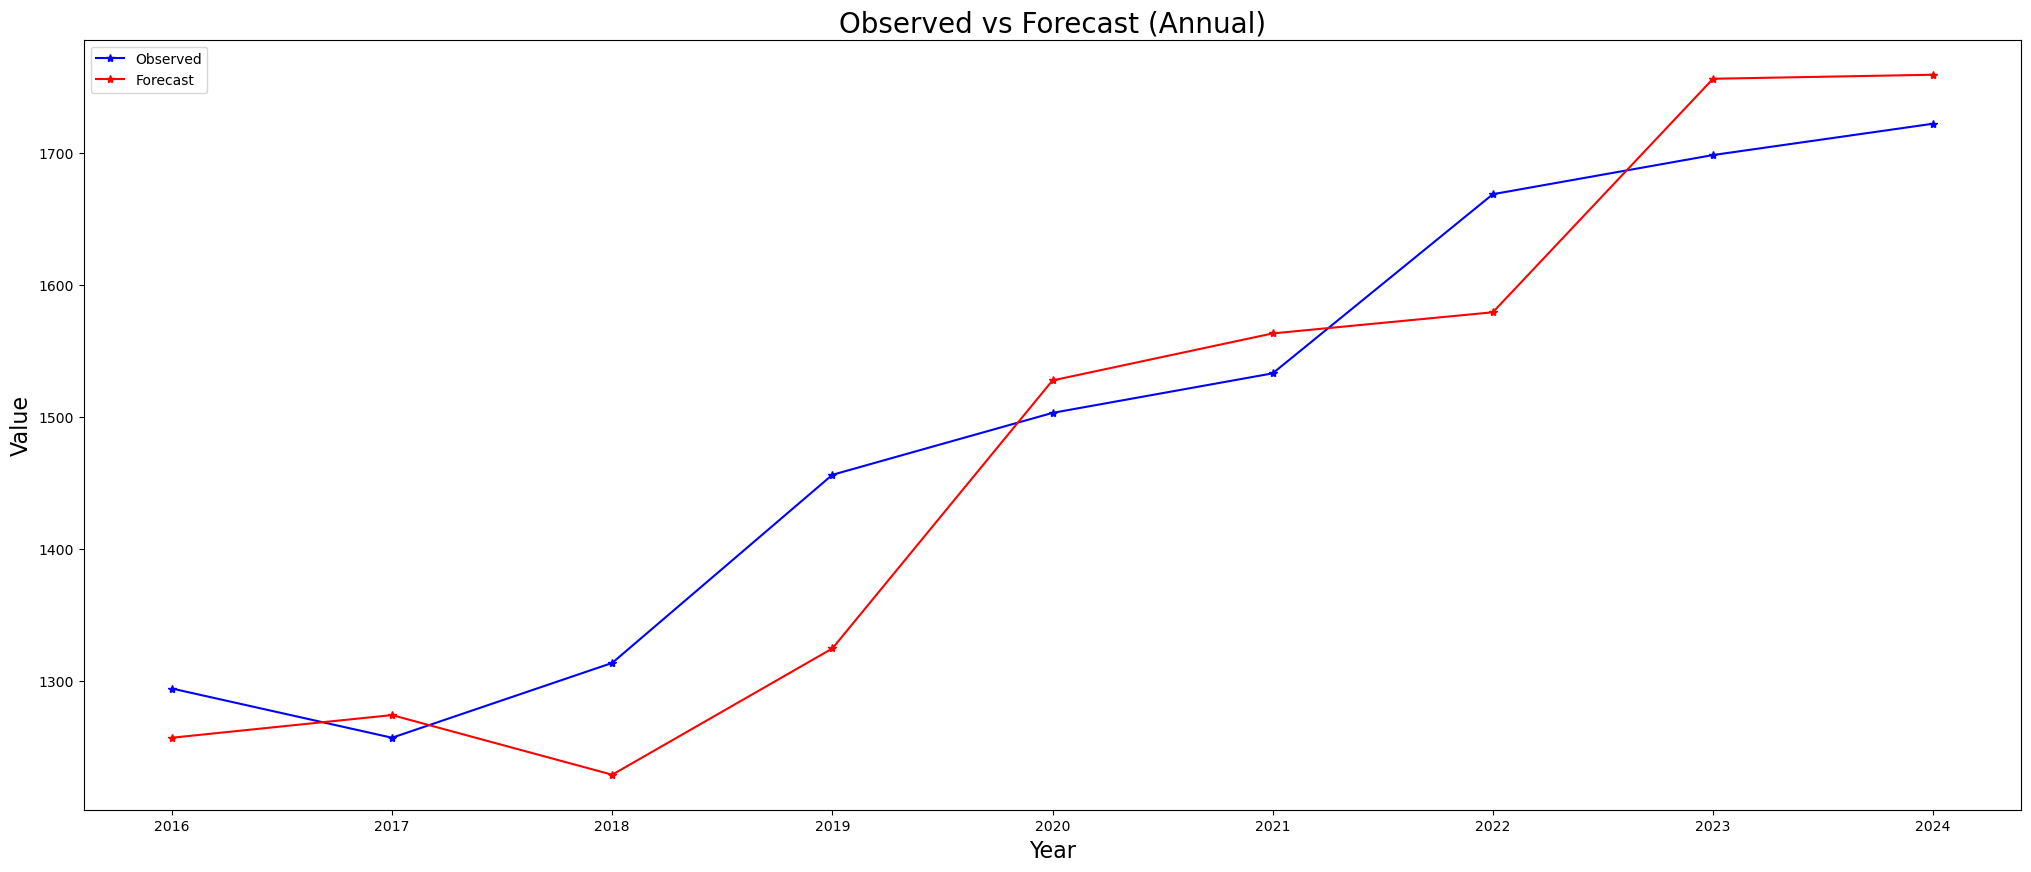

In [15]:
plt.figure(figsize=(25, 10))
plt.plot(df_annual['Demand'], '-*', color='blue', label='Observed')
plt.plot(df_annual['Forecast'], '-*', color='red', label='Forecast')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.title('Observed vs Forecast (Annual)', fontsize=20)
plt.legend(loc='best')
plt.show()

### Forecast future value

In [16]:
future_annual_pred = annual_model.forecast(3) # Forecast next two years
future_annual_pred.index = pd.to_datetime(future_annual_pred.index).strftime('%Y')
print("\nFuture Annual Forecast:\n", future_annual_pred)


Future Annual Forecast:
 2025    1765.559063
2026    1809.302616
2027    1853.046169
dtype: float64


### Combine fitted + forecast

In [17]:
pred_annual_combined = pd.concat([df_annual['Forecast'], future_annual_pred])

### Plot extended annual forecast

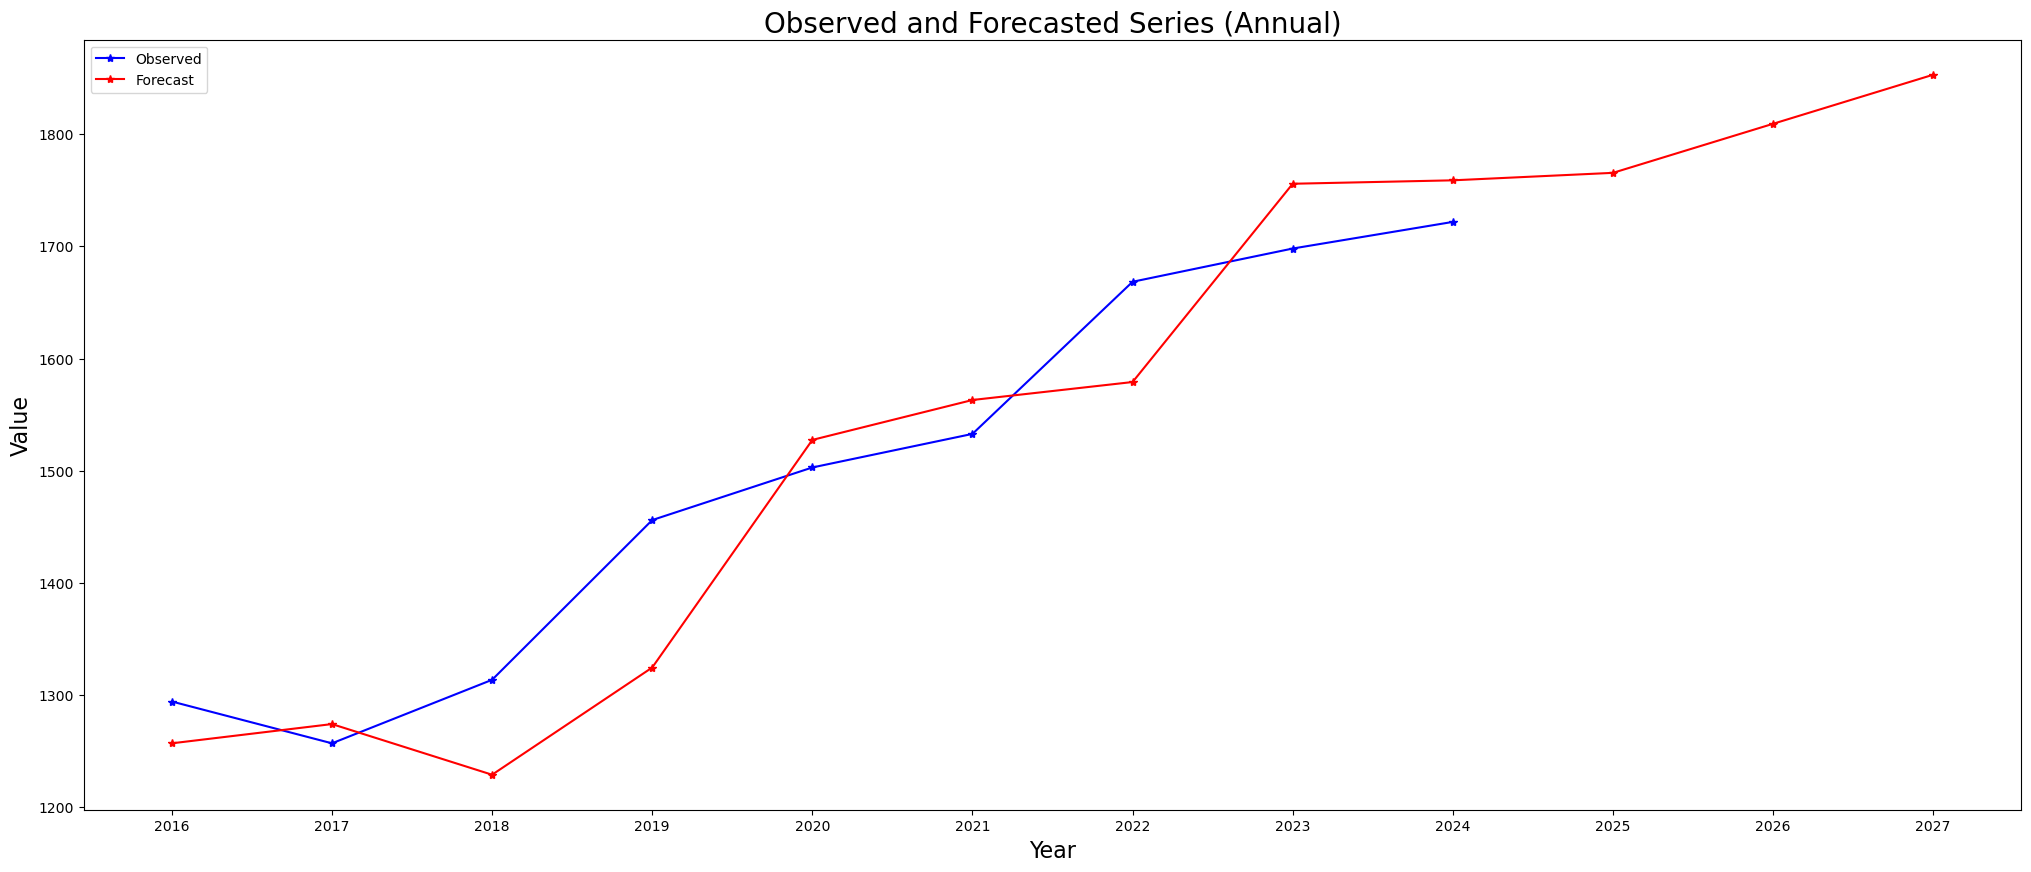

In [18]:
plt.figure(figsize=(25, 10))
plt.plot(df_annual['Demand'], '-*', color='blue', label='Observed')
plt.plot(pred_annual_combined, '-*', color='red', label='Forecast')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.title('Observed and Forecasted Series (Annual)', fontsize=20)
plt.legend(loc='best')
plt.show()

### Error metrics for annual data

In [19]:
annual_mse = mean_squared_error(df_annual['Demand'], df_annual['Forecast'])
annual_mape = mean_absolute_percentage_error(df_annual['Demand'], df_annual['Forecast'])

print(f"Annual Mean Squared Error (MSE): {annual_mse:.2f}")
print(f"Annual Mean Absolute Percentage Error (MAPE): {annual_mape * 100:.2f}%")

Annual Mean Squared Error (MSE): 4483.13
Annual Mean Absolute Percentage Error (MAPE): 3.80%
